# Simple Project to Illustrate kNN Models

**Objective**: Gain skills in kNN regression modeling, and supervised and unsupervised learning.

To achieve the objective, in this notebook I perform various analysis to understand the outcome of the efforts of a bank based in Portugal with one of its direct marketing campaigns (recurring phone calls). I will use demograhics data, individual credit status, and campaign activity information, to predict whether a a client will subscribe to one of the bank's products.

## Bank Marketing Data Set Description

The data set I decided to use for this project is the "Bank Marketing Data Set" which can be found at [The Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php). This specific data set can be found [here](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing), and was used in "A Data-Driven Approach to Predict Success of Bank Telemarketing" (Moro et al., Elsevier, 2014). The data set contains 41,188 observations for 21 variables. Their brief description is below.

We will focus our analysis on the `age`, `duration`, `campaign`, `y`, `job`, `education`, and `month` variables. A more thorough analysis would also look at the other variables in the data.

### Bank client data

- `age` (numeric)

- `job` : type of job (categorical: `admin.`, `blue-collar`, `entrepreneur`, `housemaid`, `management`, `retired`, `self-employed`, `services`, `student`, `technician`, `unemployed`, `unknown`)

- `marital` : marital status (categorical: `divorced`, `married`, `single`, `unknown`; note: `divorced` means divorced or widowed)

- `education` (categorical: `basic.4y`, `basic.6y`, `basic.9y`, `high.school`, `illiterate`, `professional.course`, `university.degree`, `unknown`)

- `default`: has credit in default? (categorical: `no`, `yes`, `unknown`)

- `housing`: has housing loan? (categorical: `no`, `yes`, `unknown`)

- `loan`: has personal loan? (categorical: `no`, `yes`, `unknown`)

### Contact information for current campaign

- `contact`: contact communication type (categorical: `cellular`, `telephone`)

- `month`: last contact month of year (categorical: `jan`, `feb`, `mar`, ..., `nov`, `dec`)

- `day_of_week`: last contact day of the week (categorical: `mon`, `tue`, `wed`, `thu`, `fri`)

- `duration`: last contact duration, in seconds (numeric).

- `campaign`: number of contacts performed during this campaign and for this client (numeric)

### Contact information from previous campaigns

- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

- `previous`: number of contacts performed before this campaign and for this client (numeric)

- `poutcome`: outcome of the previous marketing campaign (categorical: `failure`, `nonexistent`, `success`)

### Social and economic context attributes

- `emp.var.rate`: employment variation rate. quarterly indicator (numeric)

- `cons.price.idx`: consumer price index. monthly indicator (numeric)

- `cons.conf.idx`: consumer confidence index. monthly indicator (numeric)

- `euribor3m`: euribor 3 month rate. daily indicator (numeric)

- `nr.employed`: number of employees. quarterly indicator (numeric)

### Output variable

- `y`: has the client subscribed a term deposit? (binary: `yes`, `no`; desired outcome: `yes`)

## Data and Code Setup

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics

% matplotlib inline

data = pd.read_csv('./data/data.csv')

## Exploratory Analysis

### General Data Structure

As we can see below, the data has the 41,188 observations and 21 variables I mentioned earlier, and all of the string values are in lower case, and separated by dots (`.`) instead of spaces. Furthermore, the data has already been cleaned for us, so I don't have to more in that regard.

In [2]:
data.shape

(41188, 21)

In [3]:
data.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon ...         1    999         0  nonexistent          1.1   
1   may         mon ...         1    999         0  nonexistent          1.1   
2   may         mon ...         1    999         0  nonexistent          1.1   
3   may         mon ...         1    999         0  nonexistent          1.1   
4   may         mon ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [4]:
interesting = ['age', 'duration', 'campaign', 'y', 'job', 'education', 'month']

### Descriptive statistics for numeric variables

We can see that the average `age` is 40, with a standard deviation of around 10 years. Our youngest subject is 17 years old, while our latest subject is 98. The average `duration`, which can be an indicator of subject engagement, is 258 seconds (around 4.3 minutes), but the corresponding standard deviation is very high compared to the mean. As we can see, our longest call lasted over 1.2 hours, which may seem excessive for this type of calls. We can also see with the `campaign` variable that most subjects were contacted 2 to 3 times, but that there's at least on person who was contacted 56 times in total, which seems very odd. We will skip the rest of the variables, as the information we have so far provides good starting points for our analysis. If it's necessary, we can later come back to those other variables for a more comprenhensive analysis.

In [5]:
data[interesting].describe()

age      duration      campaign
count  41188.00000  41188.000000  41188.000000
mean      40.02406    258.285010      2.567593
std       10.42125    259.279249      2.770014
min       17.00000      0.000000      1.000000
25%       32.00000    102.000000      1.000000
50%       38.00000    180.000000      2.000000
75%       47.00000    319.000000      3.000000
max       98.00000   4918.000000     56.000000

### Conditional means by categorical variables (`y`, `job`, `marital` and `education`)

In the following result tables we show the conditional means for numerical variables conditional on each of three categorical variables: `y`, `job`, and `education`. We can see that slightly older subjects tend to be more receptive to the product. We can also see that calls under 220 seconds (3 mins aproximately) tend to underperform. For the next table, we can see that call duration tends to be longer for retired subjects, and that students are the subjects who experience the least number of calls. Finally, in the last table, we can see that oldest subjects tend to be the most illeterate ones, but we don't get too much more interesting information from it.

In [6]:
data[interesting].groupby(by='y').mean()

age    duration  campaign
y                                   
no   39.911185  220.844807  2.633085
yes  40.913147  553.191164  2.051724

In [7]:
data[interesting].groupby(by='job').mean()

age    duration  campaign
job                                           
admin.         38.187296  254.312128  2.623489
blue-collar    39.555760  264.542360  2.558461
entrepreneur   41.723214  263.267857  2.535714
housemaid      45.500000  250.454717  2.639623
management     42.362859  257.058140  2.476060
retired        62.027326  273.712209  2.476744
self-employed  39.949331  264.142153  2.660802
services       37.926430  258.398085  2.587805
student        25.894857  283.683429  2.104000
technician     38.507638  250.232241  2.577339
unemployed     39.733728  249.451677  2.564103
unknown        45.563636  239.675758  2.648485

In [8]:
data[interesting].groupby(by='education').mean()

age    duration  campaign
education                                           
basic.4y             47.596504  264.827826  2.600575
basic.6y             40.448953  264.414485  2.556283
basic.9y             39.061208  261.291811  2.532341
high.school          37.998213  260.886810  2.568576
illiterate           48.500000  276.777778  2.277778
professional.course  40.080107  252.533855  2.586115
university.degree    38.879191  253.223373  2.563527
unknown              43.481225  262.390526  2.596187

### Correlations among `age`, `duration`, and `campaign`, conditional on `y`

As we can see below, it seems that the most effective results (those where `y == 'yes'`), occur when subjects are contacted less frequently. If subjects are contacted more than 10 times, the probability of being unsuccessful increases dramatically, as we can in the `campaign`-`age` image. We can also see two other interesting effects. First, as subjects become older, the `duration` for each call is decreased, which makes sense because subjects have become used to such calls and quickly deal with them. Second, initial calls (those with a low `campaign`) have a higher probability of lasting for longer (higher `duration`) than those for subjects which have received a bunch of them. This is probably due to the fact that subjects who have received various calls probably already have the information need, and don't need to spend too much more time on the call. It's similar to the age effect.

The above information tells us that the most effective action for the campaign is probably to call subjects who have not been contacted before, or have been contacted a couple of times at most, and keeping calls short (but above 3mins which is what we found in the previous section). We can also see that age doesn't seem to have strong effect on whether the campaign is successful or not, as the distribution seems to behave similarly across age groups (`age` distribution conditional on `y` image).

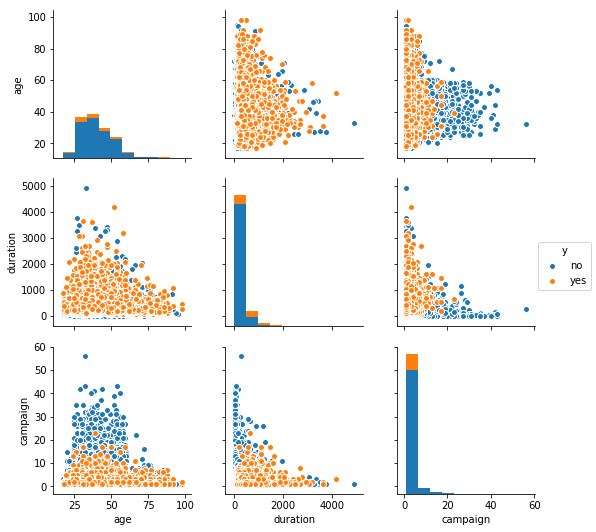

In [9]:
cols = ['age', 'duration', 'campaign', 'y']
sns.pairplot(data[cols], hue='y')

## Top frequencies for categorical variables

*NOTE: To see the summary information for the categorical variables, we specify the `include=['object', 'bool']` paremeter in the method call we used before. This allows us to see results for those object types (which are the categorical objects in our data frame).*

As we can see, most of our variables have two or three categories at most, and for those, we can make sense of them without creating any plots. For example, we can see that 36,548 observations, out of the 41,188 included in the data, belong to the `no` category for the `y` variable, which is the one we will attempt to predict in upcoming sections. This means that 88% of the data belongs to the `no` category, which implies an imbalanced data set. We can also see that the `housing`, `loan`, and `contact` variables appear to be more evenly distributed (since the frequency for the top categeory is not a large percentage of the observations).

In [10]:
data[interesting].describe(include=['object', 'bool'])

y     job          education  month
count   41188   41188              41188  41188
unique      2      12                  8     10
top        no  admin.  university.degree    may
freq    36548   10422              12168  13769

Now we will create bar graphs for those variables for which we have a larger number of categories: `job`, `education`, and `month`.

### Conditional distributions for `job`

We can see that subjects are mostly administrators, *blue-collar*, technician, or in the services industry. In the graph below we attempt to show the `job` distribution conditional on the `y` value, but it's hard to pinpoint the differences, so what we do in the following two graph is explicitly plot each conditional distribution by filtering the data we pass to the `sns.factorplot()` method. Note that we are using the same `order` in all of them to make sure results are easily comparable (if we don't use that parameter, the order in the x-axis may change from plot to plot).


After comparing the second two plots, we can see that administrators and students tend to be open to trying or purchasing the particular product being offered (which is unknown to us, so we can't provide deeper conclusions about it), and we can also see that *blue-collar* and entrepreneurs are more inclined towards reject the product.

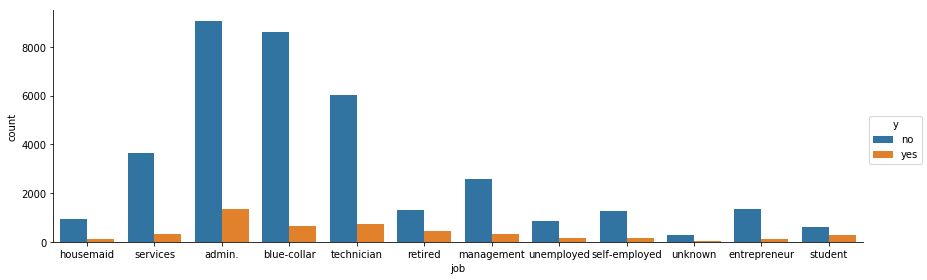

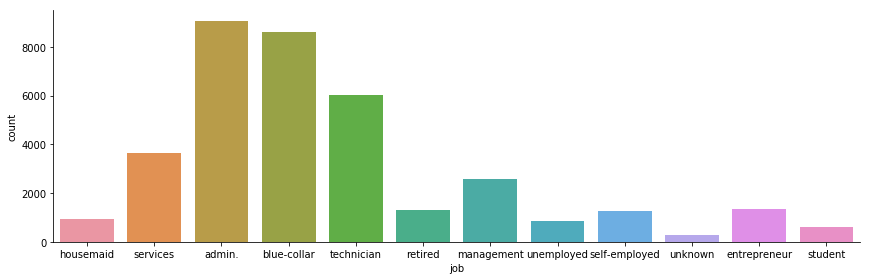

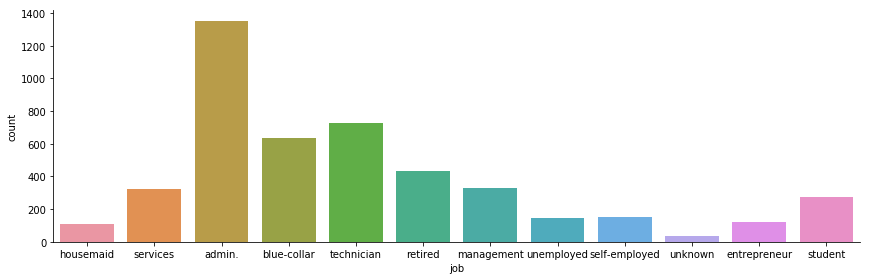

In [11]:
order = data.job.unique()
sns.factorplot(x='job', data=data, kind='count', hue='y', aspect=3, order=order)
sns.factorplot(x='job', data=data[data.y == 'no'], kind='count', aspect=3, order=order)
sns.factorplot(x='job', data=data[data.y == 'yes'], kind='count', aspect=3, order=order)

### Conditional distributions for `education`

A similar analysis for the `education` variable, shows no big difference between both conditional distributions.

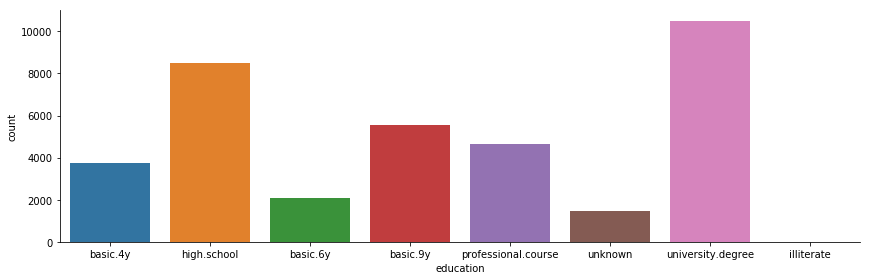

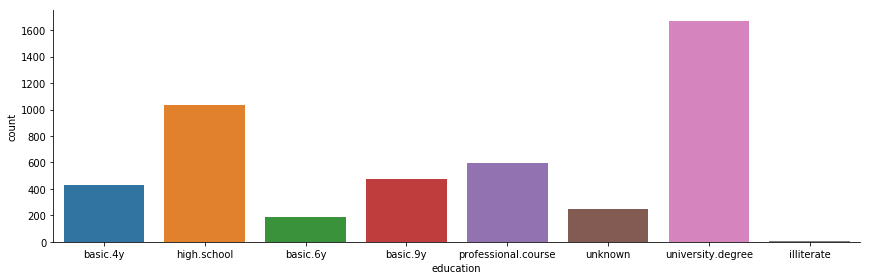

In [12]:
order = data.education.unique()
sns.factorplot(x='education', data=data[data.y == 'no'], kind='count', aspect=3, order=order)
sns.factorplot(x='education', data=data[data.y == 'yes'], kind='count', aspect=3, order=order)

### Conditional distributions for `month`

A similar analysis for the `month` variable, shows a significant increase in the positive acceptance of the product for the September and October months. There probably is an underlying reason for this, but it's unknown to me at this point.

*NOTE: in this case we specified the order ourselves instead of extracting it from the data. Two reasons are behind this: first we want to ensure a specific order for the months so that it's intuitive, and, second, we want to include those categories which are not present in the data (January, February, and December) to get a "full year view"*.

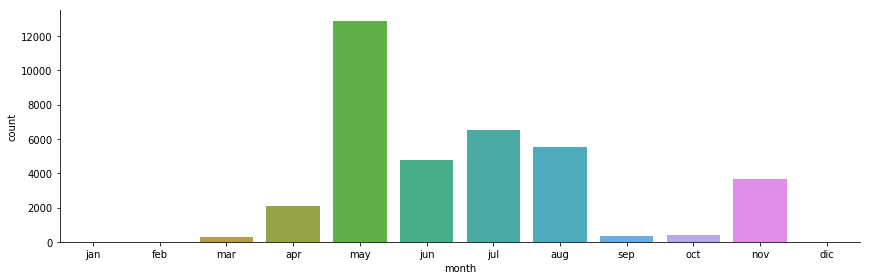

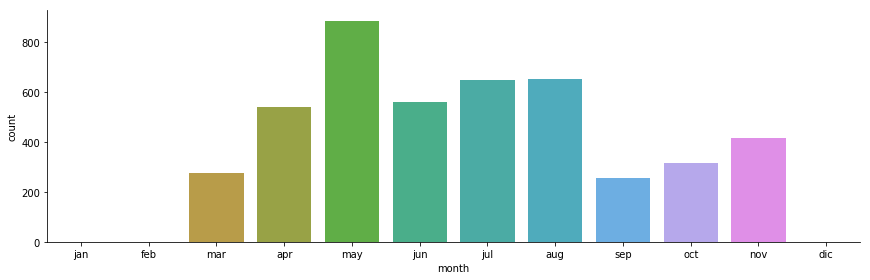

In [13]:
order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dic']
sns.factorplot(x='month', data=data[data.y == 'no'], kind='count', aspect=3, order=order)
sns.factorplot(x='month', data=data[data.y == 'yes'], kind='count', aspect=3, order=order)

### Correlations among `job`, `education`, and `y`

The following graph shows some interestnig relations. For example, as we saw before, there is a slight correlation among subjects who are receptive to the product being offered and subjects who are either students or retired (as can be seen the slightly lighter column in such coordinates). We can also see there are some clear relations among subjects being in a *blue-collar* position and having been only through basic education, and subjects being in the services or administration and having been to high school. Similarly, there are other interesting relations like that in the graph which we skip for now.

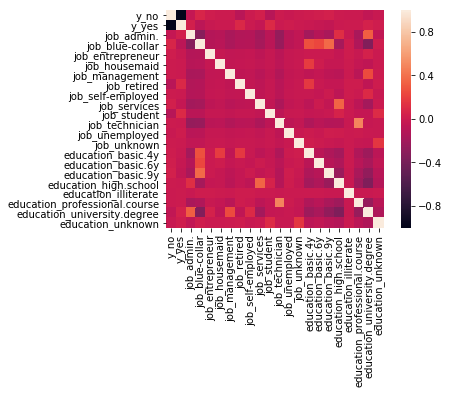

In [14]:
subset = ['job', 'education', 'y']
dummies = pd.get_dummies(data[subset], columns =['y', 'job', 'education'])
sns.heatmap(dummies.corr(), square=True, yticklabels=True, xticklabels=True)

With what we have seen so far in our exploratory analysis, there appear to be relations we can exploit for our analysis in the upcoming sections.

## Part 1 — kNN Regression Models

Since this is a regression model exercise, I can't use the `y` variable (suggested as the main variable we want to predict in this data set) as it is in the data because it's categorical. Instead, the problem I'll focus on is: **predict the `duration` (number of seconds a call lasts) using the `age` and `campaign` variables**. All of the variables in this specification are numeric, so we should not have any problems performing kNN regression in this case.

*NOTE: If we wanted to actually use categorical variables in our regression models, we could, but we would have to define the metric among those categories in a congruent way with the scales in the other variables we have. So to avoid those technicalities, we focus only on numeric variables.*

### Initial Setup

In [15]:
weights = 'uniform'
n_neighbors = 5

duration = data.as_matrix(['duration'])
campaign = data.as_matrix(['campaign'])
age = data.as_matrix(['age'])

duration_normalized = (duration - duration.mean()) / (duration.max() - duration.min())
campaign_normalized = (campaign - campaign.mean()) / (campaign.max() - campaign.min())
age_normalized = (age - age.mean()) / (age.max() - age.min())

def regression_goodness_of_fit(y, y_hat):
    ss_total = 0
    ss_residual = 0
    ss_regression = 0
    y_mean = y.mean()
    
    for i in range(len(y)):
        ss_total += np.square(y[i] - y_mean)
        ss_residual += np.square(y[i] - y_hat[i])
        ss_regression += np.square(y_hat[i] - y_mean)
    
    r_square = ss_regression / ss_total
    rmse = np.sqrt(ss_residual / float(len(y)))
    
    return {'R2': r_square[0], 'RMSE': rmse[0]}

### Model 1: `duration` by `age`

{'R2': 0.5236372539741754, 'RMSE': 319.9351159030241}


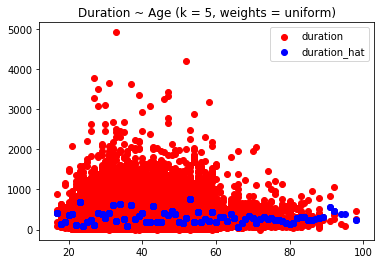

In [16]:
knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
mod = knn.fit(age, duration)
duration_hat = mod.predict(age)
print(regression_goodness_of_fit(duration, duration_hat))

plt.title('Duration ~ Age (k = {}, weights = {})'.format(n_neighbors, weights))
plt.scatter(age, duration, c='r', label='duration')
plt.scatter(age, duration_hat, c='b', label='duration_hat')
plt.axis('tight')
plt.legend()
plt.show()

### Model 2: `duration` by `campaign`

{'R2': 0.06648745633581132, 'RMSE': 268.5343579659443}


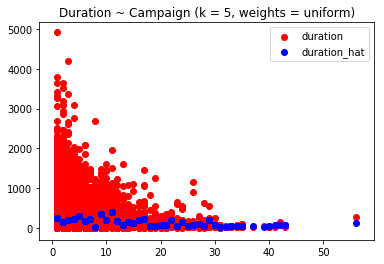

In [17]:
knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
mod = knn.fit(campaign, duration)
duration_hat = mod.predict(campaign)
print(regression_goodness_of_fit(duration, duration_hat))

plt.title('Duration ~ Campaign (k = {}, weights = {})'.format(n_neighbors, weights))
plt.scatter(campaign, duration, c='r', label='duration')
plt.scatter(campaign, duration_hat, c='b', label='duration_hat')
plt.axis('tight')
plt.legend()
plt.show()

### Model 3: `duration` by `age` (both normalized)

{'R2': 0.5236372539743064, 'RMSE': 0.06505390725966316}


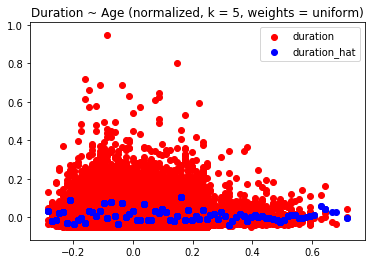

In [18]:
knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
mod = knn.fit(age_normalized, duration_normalized)
duration_hat = mod.predict(age_normalized)
print(regression_goodness_of_fit(duration_normalized, duration_hat))

plt.title('Duration ~ Age (normalized, k = {}, weights = {})'.format(n_neighbors, weights))
plt.scatter(age_normalized, duration_normalized, c='r', label='duration')
plt.scatter(age_normalized, duration_hat, c='b', label='duration_hat')
plt.axis('tight')
plt.legend()
plt.show()

### Model 4: `duration` by `campaign` (both normalized)

{'R2': 0.0664874563358437, 'RMSE': 0.054602350135407915}


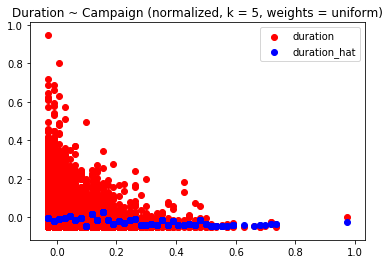

In [19]:
knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
mod = knn.fit(campaign_normalized, duration_normalized)
duration_hat = mod.predict(campaign_normalized)
print(regression_goodness_of_fit(duration_normalized, duration_hat))

plt.title('Duration ~ Campaign (normalized, k = {}, weights = {})'.format(n_neighbors, weights))
plt.scatter(campaign_normalized, duration_normalized, c='r', label='duration')
plt.scatter(campaign_normalized, duration_hat, c='b', label='duration_hat')
plt.axis('tight')
plt.legend()
plt.show()

### Finding the optimum number of neighbors and metric for Model 3

In [ ]:
weights = ['uniform', 'distance']

best_rmse_combination = {'k': 0, 'w': ''}
best_r2_combination = {'k': 0, 'w': ''}
lowest_rmse = 1000
highest_r2 = 0

for w in weights:
    for k in range(1, 1000, 10):
        print('Testing :: w: {}, k: {}'.format(w, k))
        knn = neighbors.KNeighborsRegressor(k, weights=w)
        mod = knn.fit(age_normalized, duration_normalized)
        duration_hat = mod.predict(age_normalized)
        
        results = regression_goodness_of_fit(duration_normalized, duration_hat)
        current_rmse = results['RMSE']
        current_r2 = results['R2']
        
        if current_rmse < lowest_rmse:
            lowest_rmse = current_rmse
            best_rmse_combination['k'] = k
            best_rmse_combination['w'] = w
        
        if current_r2 > highest_r2:
            highest_r2 = current_r2
            best_r2_combination['k'] = k
            best_r2_combination['w'] = w

print(best_rmse_combination)
print(best_r2_combination)

Testing :: w: uniform, k: 1
Testing :: w: uniform, k: 11
Testing :: w: uniform, k: 21
Testing :: w: uniform, k: 31
Testing :: w: uniform, k: 41
Testing :: w: uniform, k: 51
Testing :: w: uniform, k: 61
Testing :: w: uniform, k: 71
Testing :: w: uniform, k: 81
Testing :: w: uniform, k: 91
Testing :: w: uniform, k: 101
Testing :: w: uniform, k: 111
Testing :: w: uniform, k: 121
Testing :: w: uniform, k: 131
Testing :: w: uniform, k: 141
Testing :: w: uniform, k: 151
Testing :: w: uniform, k: 161
Testing :: w: uniform, k: 171
Testing :: w: uniform, k: 181
Testing :: w: uniform, k: 191
Testing :: w: uniform, k: 201
Testing :: w: uniform, k: 211
Testing :: w: uniform, k: 221
Testing :: w: uniform, k: 231
Testing :: w: uniform, k: 241
Testing :: w: uniform, k: 251
Testing :: w: uniform, k: 261
Testing :: w: uniform, k: 271
Testing :: w: uniform, k: 281
Testing :: w: uniform, k: 291
Testing :: w: uniform, k: 301
Testing :: w: uniform, k: 311
Testing :: w: uniform, k: 321
Testing :: w: uniform

As can be een from the results of the double for-loop, when optimizing for RMSE the best model uses 991 neighbors and the "distance" weights, and when optimizing for R^2 the best model uses 1 neighbor and the "uniform" distance. These seem to be overfitting for both metrics, and it probably is the case because I'm not using a training and a testing set, so all the observations used for testing were already "seen" by algorithm in the training phase. If I used the training and testing data set split, results probably would be different. 

Also, what I see here is that the RMSE optimization actually did not improve that specific metric too much from what we had before, but the R^2 was negatively affected. When optimizing for R^2, we got a single neighbor as a result of the lack of data split mentioned before.

Finally, I should mention that due to computational restrictions, I did not try every single possible `k` value between 1 and 1000 (the range of `k` I used to test), but I did it with increments of 10 instead. With that, I tested 100 `k` values for each metric.

The visual results for both models are shown in the graphs below.

### Best RMSE Model

{'R2': 0.001973209382664769, 'RMSE': 0.05268054964134377}


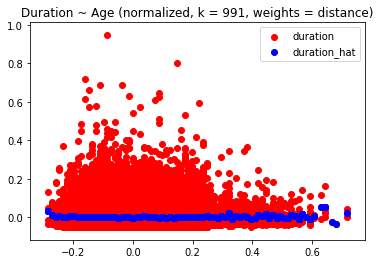

In [22]:
knn = neighbors.KNeighborsRegressor(best_rmse_combination['k'], weights=best_rmse_combination['w'])
mod = knn.fit(age_normalized, duration_normalized)
duration_hat = mod.predict(age_normalized)
print(regression_goodness_of_fit(duration_normalized, duration_hat))

plt.title('Duration ~ Age (normalized, k = {}, weights = {})'.format(best_rmse_combination['k'], best_rmse_combination['w']))
plt.scatter(age_normalized, duration_normalized, c='r', label='duration')
plt.scatter(age_normalized, duration_hat, c='b', label='duration_hat')
plt.axis('tight')
plt.legend()
plt.show()

### Best R^2 Model

{'R2': 1.0139895930089717, 'RMSE': 0.07506001310229059}


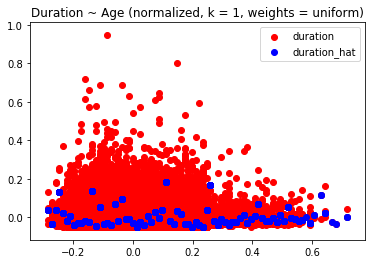

In [23]:
knn = neighbors.KNeighborsRegressor(best_r2_combination['k'], weights=best_r2_combination['w'])
mod = knn.fit(age_normalized, duration_normalized)
duration_hat = mod.predict(age_normalized)
print(regression_goodness_of_fit(duration_normalized, duration_hat))

plt.title('Duration ~ Age (normalized, k = {}, weights = {})'.format(best_r2_combination['k'], best_r2_combination['w']))
plt.scatter(age_normalized, duration_normalized, c='r', label='duration')
plt.scatter(age_normalized, duration_hat, c='b', label='duration_hat')
plt.axis('tight')
plt.legend()
plt.show()

### Conclusions

Whether `age` or `campaign` was more effective to predict `duration` depends on the metric I use to judge it. If I use the R^2 metric, `age` has by far more predictive power; mostly due to the fact that the distribution is not as skewed as the one for `campaign`. If I use RMSE as the metric however, `campaign` is a better predictor because even though the data is skewed, most of it is concentrated on the "floor" of the range, so it's close to the predicted values, and therefore has a lower RMSE. By looking at the graphs though, intuitively it seems that `age` is a better predictor given how kNN model operate, since I could move, in average, closer to the most dense part of the distribution by increasing the number of neighbors, and I could further control using different distance metrics.

I actually tried both models with normalized values to remove any unit/scale effects, given that kNN models are affected by them, and the results were drastically improved for the RMSE metric, and while the R^2 difference stayed more or less the same among both models (given that that measure is not affected by units), the RMSE changed quite a bit, and it's much closer among both models this way.

I think that the prediction models are reliable, but I would not recommend them to a client until I did further testing using more models (possibly combining multiple features in a single model, and trying with even more neighbors), as well as using a training/testing data split with cross validation to make sure the results are valid. I would expect the model to maintain its accuracy if the variables are normalized again after we have the new data, otherwise I wouldn't because the unit effect can be large for values outside of the current ranges.

## Part 2 — Supervised Learning

**Predict subscriptions (`y == yes`) with two models: `duration`-`campaign` and `age`-`duration`, using 5 and 20 neighbors.**

### Setup

First we setup the colors for the graphs, the grid size (`h`), and the dependent variable. Note that during each model we use a different mechanism to achieve the same normalization effect we used before; in this case we use the `MinMaxScaler()` provided by `sklearn`.

In [220]:
h = 0.011  # Step size in mesh
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

y = data.as_matrix(['y']) == 'yes'

### Model 1: `y` by `duration` and `campaign` with 50 neighbors

Model score: 0.894945129649


Text(0.5,1,'2-Class classification with kNN (k = 50)')

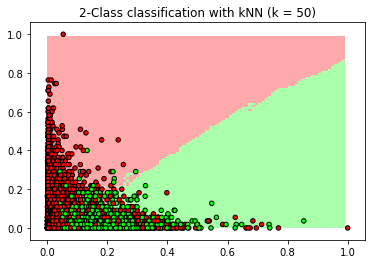

In [224]:
n_neighbors = 50

X = data[['duration', 'campaign']]
mms = preprocessing.MinMaxScaler()
X = mms.fit_transform(X)

knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
mod = knn.fit(X, y.ravel())
print('Model score: {}'.format(knn.score(X, y.ravel())))

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

z = mod.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure()
plt.pcolormesh(xx, yy, z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolor='k', s=20, cmap=cmap_bold)
plt.title('2-Class classification with kNN (k = {})'.format(n_neighbors))

### Model 2: `y` by `duration` and `campaign` with 6 neighbors

Model score: 0.90137904244


Text(0.5,1,'2-Class classification with kNN (k = 6)')

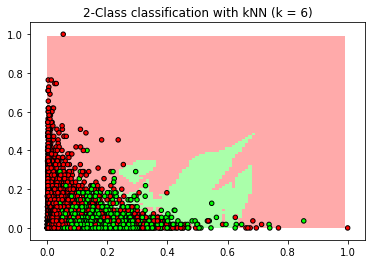

In [225]:
n_neighbors = 6

X = data[['duration', 'campaign']]
mms = preprocessing.MinMaxScaler()
X = mms.fit_transform(X)

knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
mod = knn.fit(X, y.ravel())
print('Model score: {}'.format(knn.score(X, y.ravel())))

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

z = mod.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure()
plt.pcolormesh(xx, yy, z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolor='k', s=20, cmap=cmap_bold)
plt.title('2-Class classification with kNN (k = {})'.format(n_neighbors))

### Model 3: `y` by `age` and `duration` with 50 neighbors

Model score: 0.897348742352


Text(0.5,1,'2-Class classification with kNN (k = 50)')

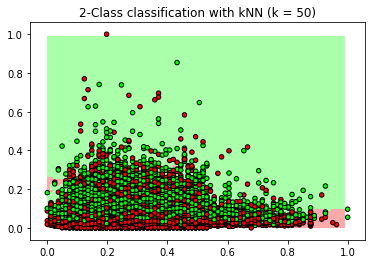

In [237]:
n_neighbors = 50

X = data[['age', 'duration']]
mms = preprocessing.MinMaxScaler()
X = mms.fit_transform(X)

knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
mod = knn.fit(X, y.ravel())
print('Model score: {}'.format(knn.score(X, y.ravel())))

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

z = mod.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure()
plt.pcolormesh(xx, yy, z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolor='k', s=20, cmap=cmap_bold)
plt.title('2-Class classification with kNN (k = {})'.format(n_neighbors))

### Model 4: `y` by `age` and `duration` with 6 neighbors

Model score: 0.906259104594


Text(0.5,1,'2-Class classification with kNN (k = 6)')

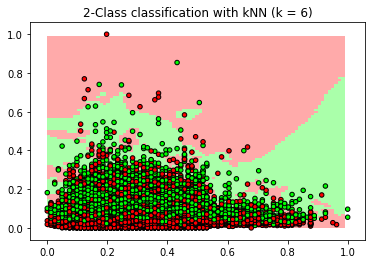

In [236]:
n_neighbors = 6

X = data[['age', 'duration']]
mms = preprocessing.MinMaxScaler()
X = mms.fit_transform(X)

knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
mod = knn.fit(X, y.ravel())
print('Model score: {}'.format(knn.score(X, y.ravel())))

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

z = mod.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure()
plt.pcolormesh(xx, yy, z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolor='k', s=20, cmap=cmap_bold)
plt.title('2-Class classification with kNN (k = {})'.format(n_neighbors))

As can be seen in the results, models with 50 neighbors underperform the models with only 6 neighbors. Of course, this is a tradeoff, because the simpler decision boundary from using 50 neighbors may be more intuitive to interpret and make decisions, at the cost of a less accurate predictive model.

Again, to be sure that we're using the right model I would need to split the data into training/testing samples, and use that for testing. Without doing that, it's hard to say whether the model has good predictive power. Howerver, it can be seen that the decision boundaries the algorithm provides match well the pattern observed in the actual data (scatterplot) for the `duration`-`campaign` models, and not so much for the `age`-`duration` models, where the `age` variable doesn't provide to much information for classification.

## Part 3 — Unsupervised Learning

**Attempt to find cluster for `y` using `duration` and `campaign`, as before.**

In [230]:
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

### Model 1: 2 clusters using `duration`-`campaign`

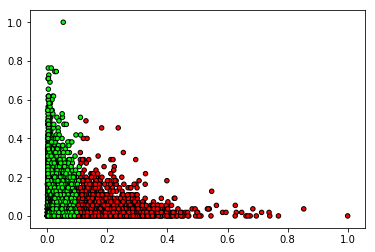

In [233]:
X = data[['duration', 'campaign']]
mms = preprocessing.MinMaxScaler()
X = mms.fit_transform(X)

y_hat = KMeans(n_clusters=2).fit_predict(X)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y_hat, edgecolor='k', s=20, cmap=cmap_bold)

### Model 2: 2 clusters using `age`-`duration`

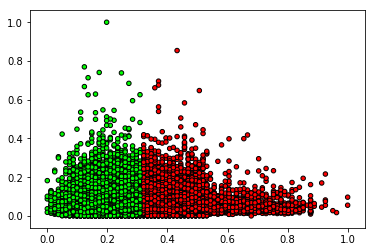

In [238]:
X = data[['age', 'duration']]
mms = preprocessing.MinMaxScaler()
X = mms.fit_transform(X)

y_hat = KMeans(n_clusters=2).fit_predict(X)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y_hat, edgecolor='k', s=20, cmap=cmap_bold)

In this case we see that Model 1 provided a boundary with an effect similar to the one from `duration`-`campaign` supervised model with 50 neighbors. This can be reassuring that it could be a useful boundary. In the case of Model 2, we see that the clusters found are useless when compared with the actual data (scatterplots) from models 3 and 4 from the previous section.

In both cases we can see that the data distribution pushed the algorithm towards a vertical decision boundary, which was exepcted, as there's no classification data to train the algorithm as in the supervised learning case.